In [2]:
import pandas as pd
import numpy as np
import re
import os
from pathlib import PurePath
from utils import Identity, compute_identity_stats, read_json, generate_esm2_embeddings
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#1C7ED6', '#77DD77', '#FFB347', '#FF6961', '#17BECF', '#F4D35E', "#ADFF2F", "#FF8200"])

/Users/anthonylavertu/mac_docs/pycharmProjects/QMAP/data_leakage/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MIN_SEQ_LEN = 1
MAX_SEQ_LEN = 100

In [4]:
if not os.path.exists(".cache/figs"):
    os.makedirs(".cache/figs")

# Filter dataset

In [5]:
data = read_json("../data/build/dataset.json")
dataset = [(sample["ID"], sample["Sequence"]) for sample in data if MIN_SEQ_LEN <= len(sample["Sequence"]) <= MAX_SEQ_LEN]
output_path = ".cache/cdhit/dataset.fasta"
if not os.path.exists(PurePath(output_path).parent):
    os.makedirs(PurePath(output_path).parent)
with open(output_path, 'w') as f:
    for id_, seq in dataset:
        f.write(f">{id_}\n{seq}\n")
print(f"Filtered dataset saved to {output_path}")

Filtered dataset saved to .cache/cdhit/dataset.fasta


# Cluster sequences

In [6]:
!cd-hit -i ".cache/cdhit/dataset.fasta" -o ".cache/cdhit/clusters" -c 0.55 -n 2 -d 0 -M 30000 -T 10 -l 1

Program: CD-HIT, V4.8.1 (+OpenMP), Jun 25 2025, 18:10:39
Command: cd-hit -i .cache/cdhit/dataset.fasta -o
         .cache/cdhit/clusters -c 0.55 -n 2 -d 0 -M 30000 -T 10
         -l 1

Started: Wed Oct 22 10:07:46 2025
                            Output                              
----------------------------------------------------------------
Your word length is 2, using 3 may be faster!
total seq: 18975
longest and shortest : 100 and 2
Total letters: 323998
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 2M
Buffer          : 10 X 10M = 107M
Table           : 2 X 0M = 0M
Miscellaneous   : 0M
Total           : 110M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 3736145411

# comparing sequences from          0  to       1581
.---------- new table with      561 representatives
# comparing sequences from       1581  to       3030
99.9%---------- new table with      294 represe

# Load clusters

In [7]:
def parse_cdhit_clstr(clstr_path: str) -> pd.DataFrame:
    """
    Parses a CD-HIT .clstr file and returns a DataFrame with cluster and sequence IDs.

    Parameters:
    - clstr_path (str): Path to the .clstr file.

    Returns:
    - pd.DataFrame with columns: cluster_id, sequence_id
    """
    clusters = []
    current_cluster = -1

    with open(clstr_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>Cluster'):
                current_cluster += 1
            elif line:
                # Extract sequence ID from the line
                match = re.search(r'>?([\w|:.\-]+)\.\.\.', line)
                if match:
                    seq_id = int(match.group(1))
                    clusters.append((current_cluster, seq_id))
                else:
                    raise ValueError(f"Could not parse sequence ID from line: {line}")

    return pd.DataFrame(clusters, columns=["cluster_id", "sequence_id"])
clusters = parse_cdhit_clstr(".cache/cdhit/clusters.clstr")

# Split clusters into two sets

In [8]:
def split_clusters(clusters, test_ratio: float = 0.2):
    """
    Splits the clusters into training and test sets based on a given test ratio.
    :param clusters: The clusters DataFrame containing sequence IDs and their corresponding cluster IDs.
    :param test_ratio: The ratio of sequences to be included in the test set.
    :return: Two sets of ids, one for training and one for testing.
    """
    cluster_ids = clusters['cluster_id'].unique()
    np.random.shuffle(cluster_ids)
    print("Found", len(cluster_ids), "clusters.")
    n_test = int(len(cluster_ids) * test_ratio) # Number of clusters to be used for testing
    test_clusters = set(cluster_ids[:n_test])
    train_clusters = set(cluster_ids[n_test:])
    train_ids = clusters[clusters['cluster_id'].isin(train_clusters)]['sequence_id'].tolist()
    test_ids = clusters[clusters['cluster_id'].isin(test_clusters)]['sequence_id'].tolist()
    return train_ids, test_ids

train_ids, test_ids = split_clusters(clusters)
len(train_ids), len(test_ids)

Found 2054 clusters.


(15041, 3934)

# Assert independence between training and test sets

In [9]:
identity_calculator = Identity()

identities, true_train_set = compute_identity_stats(train_ids, test_ids, identity_calculator=identity_calculator)
if np.isnan(identities).any():
    print("Warning: There are NaN values in the identities array. This may indicate missing data for some sequences.")

 100%|████████████████████████████████████|  3934/3934 [00:11<00:00, 332.26it/s] 


In [10]:
test2train_id = identities.max(axis=1)

Max identity: 0.9696969696969697
Mean identity: 0.7295332363268554
Median identity: 0.7692307692307693
Quantiles:
- 0.01 quantile: 0.3333333333333333
- 0.05 quantile: 0.4146341463414634
- 0.10 quantile: 0.4666666666666667
- 0.25 quantile: 0.6
- 0.50 quantile: 0.7692307692307693
- 0.75 quantile: 0.8888888888888888
- 0.90 quantile: 0.9230769230769231
- 0.95 quantile: 0.9333333333333333
- 0.99 quantile: 0.9558695652173915
Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):
5709


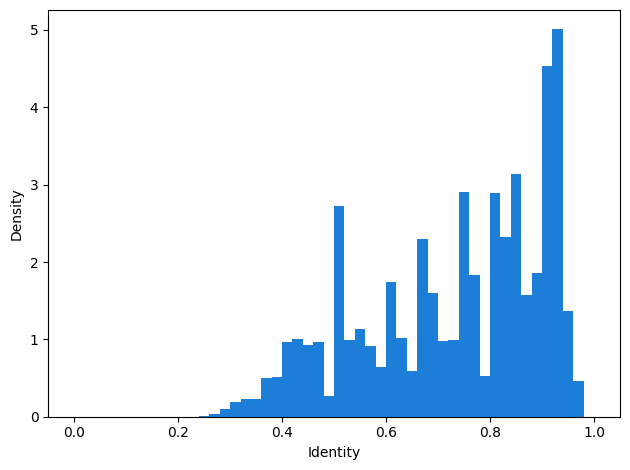

In [11]:
print(f"Max identity: {np.max(test2train_id)}")
print(f"Mean identity: {np.mean(test2train_id)}")
print(f"Median identity: {np.median(test2train_id)}")
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(test2train_id, q)}")

print("Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):")
print(np.sum(true_train_set))
plt.hist(test2train_id, bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
# plt.title("Highest identity between each test sequence and all train sequences")
plt.tight_layout()
plt.savefig(".cache/figs/cdhit_split.svg")

In [12]:
print(f"Length of train dataset: {len(train_ids)}")

Length of train dataset: 15041


In [13]:
# Get train/test sequences
train_seqs = [sample["Sequence"] for sample in data if sample["ID"] in train_ids]
test_seqs = [sample["Sequence"] for sample in data if sample["ID"] in test_ids]
# Get train/test e coli MIC
train_mic = [sample["Targets"].get("Escherichia coli", (None,))[0] for sample in data if sample["ID"] in train_ids]
test_mic = [sample["Targets"].get("Escherichia coli", (None,))[0] for sample in data if sample["ID"] in test_ids]
train_mask = [mic is not None for mic in train_mic]
test_mask = [mic is not None for mic in test_mic]
train_seqs = [seq for seq, mask in zip(train_seqs, train_mask) if mask]
test_seqs = [seq for seq, mask in zip(test_seqs, test_mask) if mask]
train_mic = np.array([mic for mic in train_mic if mic is not None])
test_mic = np.array([mic for mic in test_mic if mic is not None])
print("Train mean: {}, std: {}".format(np.mean(np.log10(train_mic)), np.std(np.log10(train_mic))))
print("Test mean: {}, std: {}".format(np.mean(np.log10(test_mic)), np.std(np.log10(test_mic))))

# Generate train/test embeddings
train_X = generate_esm2_embeddings(train_seqs, batch_size=128, device="mps")
test_X = generate_esm2_embeddings(test_seqs, batch_size=128, device="mps")
# Train a linear regression model
model = LinearRegression().fit(train_X, np.log10(train_mic))
# Evaluate the model
test_pred = model.predict(test_X)
pcc = pearsonr(test_pred, np.log10(test_mic)).statistic
pcc

Train mean: 1.2999202138028991, std: 1.0035064685277744
Test mean: 1.4813086926036765, std: 1.0831669294305588


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 100%|██████████████████████████████████████████|  84/84 [14:38<00:00, 9.25s/it] 


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 100%|█████████████████████████████████████████|  23/23 [09:06<00:00, 17.18s/it] 


np.float64(0.5031607281223165)